
# Pneumonia classification

Download [pneumonia datatset form Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/data)


# Resources:

http://blog.root.cz/trpaslikuv-blog/rozpoznani-zapalu-plic-z-rtg-snimku-dil-prvni/

In [6]:
import sys
import os
import glob
import shutil
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

from keras.utils import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import Input, Model
from keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import cv2
from pathlib import Path

# sns.set_style('darkgrid')



## Data

In [13]:
# DATA_ROOT = '/kaggle/input/chest-xray-pneumonia/chest_xray'
DATA_ROOT = Path(r"H:\medical\orig\kaggle-chest-xray-pneumonia/chest_xray")

DATA_TRAIN = DATA_ROOT/ "train"
DATA_VALID = DATA_ROOT/ "val"
DATA_TEST  = DATA_ROOT/ "test"

In [14]:
print(f"{DATA_ROOT.exists()=}")


print(f"TRAINING Directory: {DATA_TRAIN.exists()=}")
for dirpath, dirnames, filenames in os.walk(DATA_TRAIN):
    if len(filenames):
        print(f"    {os.path.normpath(dirpath).lstrip(os.path.sep).split(os.path.sep)[-1]:9}: {len(filenames)}")

print("VALIDATION Directory")
for dirpath, dirnames, filenames in os.walk(DATA_VALID):
    if len(filenames):
        print(f"    {os.path.normpath(dirpath).lstrip(os.path.sep).split(os.path.sep)[-1]:9}: {len(filenames)}")

print("TESTING Directory")
for dirpath, dirnames, filenames in os.walk(DATA_TEST):
    if len(filenames):
        print(f"    {os.path.normpath(dirpath).lstrip(os.path.sep).split(os.path.sep)[-1]:9}: {len(filenames)}")

DATA_ROOT.exists()=True
TRAINING Directory: DATA_TRAIN.exists()=True
    NORMAL   : 1341
    PNEUMONIA: 3875
VALIDATION Directory
    NORMAL   : 8
    PNEUMONIA: 8
TESTING Directory
    NORMAL   : 234
    PNEUMONIA: 390


Found 16 files belonging to 2 classes.


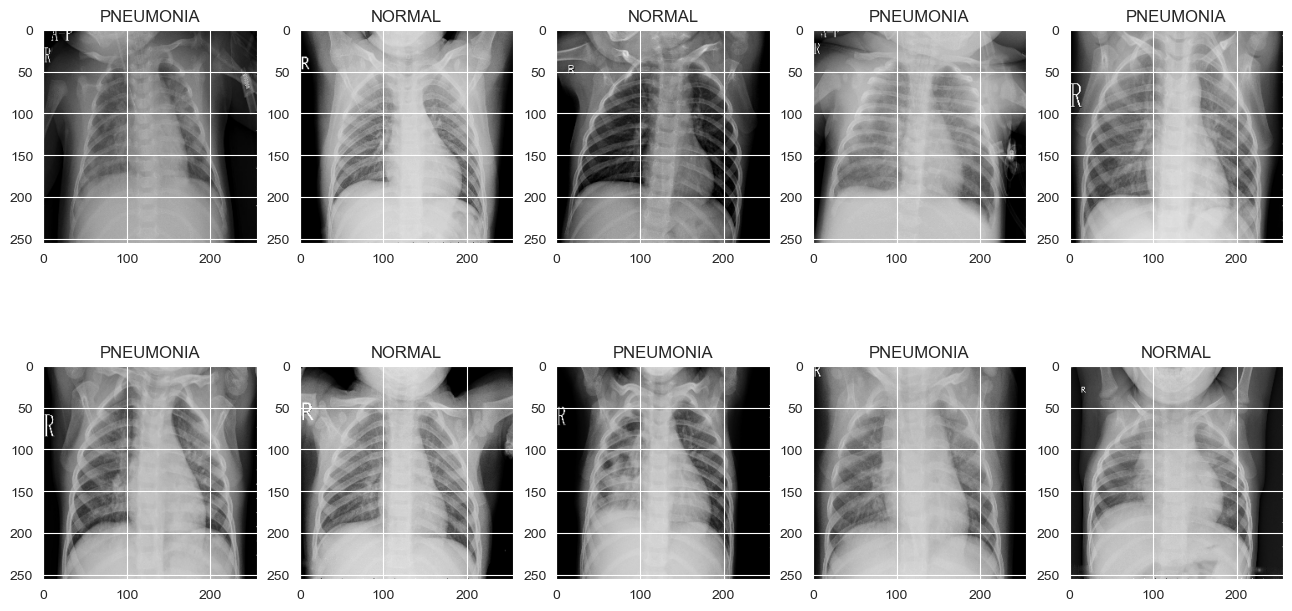

In [15]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(16, 8))
    for n in range(10):
        ax = plt.subplot(2, 5, n+1)
        plt.imshow(image_batch[n], cmap='gray')
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
#         plt.axis("off")

image_batch, label_batch = next(iter(image_dataset_from_directory(
    DATA_VALID,
    label_mode='binary',
    class_names=['NORMAL', 'PNEUMONIA'],
    color_mode='grayscale')))

show_batch(image_batch.numpy(), label_batch.numpy())

In [18]:
LABELS = ['NORMAL', 'PNEUMONIA']
IMAGE_SIZE = (224, 224)

def get_datasource(*data_dirs, flag=cv2.IMREAD_GRAYSCALE):
    x, y = list(), list()
    for data_dir in data_dirs:
        for i, label in enumerate(LABELS):
            path = os.path.join(data_dir, label)
            target = [0] * len(LABELS)
            target[i] = 1
            for img in os.listdir(path):
                if img.endswith(".jpeg"):
                    img_arr = cv2.imread(os.path.join(path, img), flag)
                    resized_arr = cv2.resize(img_arr, IMAGE_SIZE)
                    x.append(resized_arr)
                    y.append(target)
    return np.array(x) / 255, np.array(y)

## Model definition

In [17]:
def create_model_ResNet50(X_shape, classes=2, name="ResNet50"):

    def mlp(x, hidden_units, activation='relu', dropout_rate=0.3, name=""):
        for i, units in enumerate(hidden_units):
            x = layers.Dense(units, activation=activation, name=f"{name}_{i}_dense")(x)
            x = layers.Dropout(dropout_rate, name=f"{name}_{i}_dropout")(x)
        return x

    def conv_block(x, *, filters, kernel_size, strides=(1, 1), padding='same', activation='relu', name=""):
        x = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, name=f"{name}_conv")(x)
        x = layers.BatchNormalization(name=f"{name}_norm")(x)
        if activation:
            x = layers.Activation(activation, name=f"{name}_actn")(x)
        return x

    def identity_block(x, *, filters, name=""):
        shortcut = x
        x = conv_block(x, filters=filters, kernel_size=(1, 1), name=f"{name}_cb1")
        x = conv_block(x, filters=filters, kernel_size=(3, 3), name=f"{name}_cb2")
        x = conv_block(x, filters=filters * 4, kernel_size=(1, 1), activation='', name=f"{name}_cb3")
        x = layers.Add(name=f"{name}_add")([x, shortcut])
        x = layers.Activation('relu', name=f"{name}_actn")(x)
        return x

    def projection_block(x, *, filters, strides, name=""):
        shortcut = x
        x = conv_block(x, filters=filters, kernel_size=(1, 1), strides=strides, name=f"{name}_cb1")
        x = conv_block(x, filters=filters, kernel_size=(3, 3), name=f"{name}_cb2")
        x = conv_block(x, filters=filters * 4, kernel_size=(1, 1), activation='', name=f"{name}_cb3")
        shortcut = conv_block(shortcut, filters=filters * 4, kernel_size=(1, 1), strides=strides, activation='', name=f"{name}_cb4")
        x = layers.Add(name=f"{name}_add")([x, shortcut])
        x = layers.Activation('relu', name=f"{name}_actn")(x)
        return x

    inputs = Input(X_shape[-3:], name='inputs')

    # === Stage 1 ===
    x = conv_block(inputs, filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same', name="stg1_cb1")
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name="stg1_maxpool")(x)

    # === Stage 2 ===
    x = projection_block(x, filters=64, strides=(1, 1), name="stg2_pb")
    x = identity_block(x, filters=64, name="stg2_ib1")
    x = identity_block(x, filters=64, name="stg2_ib2")

    # === Stage 3 ===
    x = projection_block(x, filters=128, strides=(2, 2), name="stg3_pb")
    x = identity_block(x, filters=128, name="stg3_ib1")
    x = identity_block(x, filters=128, name="stg3_ib2")
    x = identity_block(x, filters=128, name="stg3_ib3")

    # === Stage 4 ===
    x = projection_block(x, filters=256, strides=(2, 2), name="stg4_pb")
    x = identity_block(x, filters=256, name="stg4_ib1")
    x = identity_block(x, filters=256, name="stg4_ib2")
    x = identity_block(x, filters=256, name="stg4_ib3")
    x = identity_block(x, filters=256, name="stg4_ib4")
    x = identity_block(x, filters=256, name="stg4_ib5")

    # === Stage 5 ===
    x = projection_block(x, filters=512, strides=(2, 2), name="stg5_pb")
    x = identity_block(x, filters=512, name="stg5_ib1")
    x = identity_block(x, filters=512, name="stg5_ib2")

    x = layers.GlobalAveragePooling2D(name=f"stg5_globaver")(x)

    x = mlp(x, (1024, 512), name="dense")
    outputs = layers.Dense(classes, activation='softmax', name='outputs')(x)

    return Model(inputs=inputs, outputs=outputs, name=name)

## Training

In [19]:
def evaluate_model(model, *, epochs=40, batch_size=32, forced_training=False):

    print(f"=== MODEL EVALUATION =================================================\n")

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])
    model.summary()

    MODEL_CHECKPOINT = f"/kaggle/working/model/{model.name}.ckpt"

    if not os.path.exists(MODEL_CHECKPOINT) or forced_training:
        print(f"\n--- Model training ---------------------------------------------------\n")

        shutil.rmtree(MODEL_CHECKPOINT, ignore_errors=True)

        callbacks_list = [
            keras.callbacks.EarlyStopping(
                monitor='val_auc',
                patience=10),
            keras.callbacks.ModelCheckpoint(
                filepath=MODEL_CHECKPOINT,
                monitor='val_auc',
                save_best_only=True,
                mode='max',
                verbose=1)
        ]
        history = model.fit(
            datagen.flow(x_train, y_train, batch_size=batch_size),
            epochs=epochs,
            callbacks=callbacks_list,
            validation_data=datagen.flow(x_valid, y_valid),
            verbose=1)

        print(f"\n--- Training history -------------------------------------------------\n")

        fig, ax = plt.subplots(1, 2, figsize=(16, 4))
        sns.lineplot(data={k: history.history[k] for k in ('loss', 'val_loss')}, ax=ax[0])
        sns.lineplot(data={k: history.history[k] for k in history.history.keys() if k not in ('loss', 'val_loss')}, ax=ax[1])
        plt.show()

    else:
        print(f"\n--- Model is already trainded ... loading ----------------------------\n")

    model.load_weights(MODEL_CHECKPOINT)

    print(f"\n--- Test Predictions and Metrics -------------------------------------\n")

    y_pred = model.predict(x_test, verbose=0)

    plt.figure(figsize=(6, 3))
    heatmap = sns.heatmap(confusion_matrix(np.argmax(y_test, axis=-1),  np.argmax(y_pred, axis=-1)), annot=True, fmt="d", cbar=True)
    heatmap.yaxis.set_ticklabels(LABELS, rotation=90, ha='right')
    heatmap.xaxis.set_ticklabels(LABELS, rotation=0, ha='right')
    heatmap.axes.set_ylabel('True label')
    heatmap.axes.set_xlabel('Predicted label')
    plt.show()

    print()
    print(classification_report(np.argmax(y_test, axis=-1), np.argmax(y_pred, axis=-1), target_names=LABELS, zero_division=0))

    print(f"\n=== MODEL EVALUATION FINISHED ========================================")

In [20]:
x_train, x_valid, y_train, y_valid = train_test_split(*get_datasource(DATA_TRAIN, DATA_VALID), test_size=0.2)
x_test, y_test = get_datasource(DATA_TEST)

x_train = np.expand_dims(x_train, axis=-1)
x_valid = np.expand_dims(x_valid, axis=-1)
x_test  = np.expand_dims(x_test, axis=-1)

datagen = ImageDataGenerator(
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)

datagen.fit(x_train)

In [ ]:
evaluate_model(create_model_ResNet50(x_train.shape, 2), forced_training=False)

=== MODEL EVALUATION =================================================
Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 stg1_cb1_conv (Conv2D)         (None, 112, 112, 64  3200        ['inputs[0][0]']                 
                                )                                                                 
                                                                                                  
 stg1_cb1_norm (BatchNormalizat  (None, 112, 112, 64  256        ['stg1_cb1_conv[0][0]']          
 ion)               